<a href="https://colab.research.google.com/github/ayarii/learner-engagement/blob/main/CNN%2BDA_(validation%2Btraitement).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
import pathlib
import os
import zipfile
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras import layers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split



In [2]:

#Import dataset
data_dir = tf.keras.utils.get_file(
    "dataset.zip",
    "https://github.com/ayarii/learner-engagement/blob/main/Student-engagement-dataset.zip?raw=true",
    extract=False)
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')
data_dir = pathlib.Path('/content/datasets/Student-engagement-dataset')
print(data_dir)
print(os.path.abspath(data_dir))



40069772/40069772 [==============================] - 1s 0us/step
/content/datasets/Student-engagement-dataset
/content/datasets/Student-engagement-dataset


In [3]:
import shutil

# Chemin vers le dossier contenant vos dossiers d'ensemble de données
data_dir = '/content/datasets/Student-engagement-dataset'

# Chemin vers le dossier où vous souhaitez placer les ensembles de traitement et de validation
output_dir = '/content/datasets'

# Liste des noms de dossiers dans votre ensemble de données
folder_names = os.listdir(data_dir)

# Création des dossiers de traitement et de validation s'ils n'existent pas déjà
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Répartition des données en ensembles de traitement et de validation
for folder_name in folder_names:
    folder_path = os.path.join(data_dir, folder_name)
    images = os.listdir(folder_path)
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    # Création des sous-dossiers dans les ensembles de traitement et de validation
    train_folder_path = os.path.join(train_dir, folder_name)
    val_folder_path = os.path.join(val_dir, folder_name)
    os.makedirs(train_folder_path, exist_ok=True)
    os.makedirs(val_folder_path, exist_ok=True)

    # Déplacement des images dans les sous-dossiers correspondants
    for image in train_images:
        shutil.copy(os.path.join(folder_path, image), os.path.join(train_folder_path, image))
    for image in val_images:
        shutil.copy(os.path.join(folder_path, image), os.path.join(val_folder_path, image))

print("Données divisées en ensembles de traitement et de validation avec succès.")



Données divisées en ensembles de traitement et de validation avec succès.


In [4]:
# Chemin vers les dossiers d'entraînement et de validation
train_dir = '/content/datasets/train/'
val_dir = '/content/datasets/validation/'

# Fonction pour compter le nombre total d'images dans un dossier
def count_images_in_directory(directory):
    total_images = 0
    # Parcours de chaque sous-dossier dans le répertoire
    for sub_directory in os.listdir(directory):
        sub_directory_path = os.path.join(directory, sub_directory)
        # Comptage des fichiers dans le sous-dossier
        if os.path.isdir(sub_directory_path):
            num_images = len([filename for filename in os.listdir(sub_directory_path)
                              if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg')])
            total_images += num_images
    return total_images

# Comptage du nombre total d'images dans chaque dossier
total_train_images = count_images_in_directory(train_dir)
total_val_images = count_images_in_directory(val_dir)

# Affichage du nombre total d'images dans chaque dossier
print("Nombre total d'images dans le dossier d'entraînement :", total_train_images)
print("Nombre total d'images dans le dossier de validation :", total_val_images)


Nombre total d'images dans le dossier d'entraînement : 1694
Nombre total d'images dans le dossier de validation : 426


In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers

# Chemin vers le dossier contenant vos dossiers d'ensemble de données
data_dir = '/content/datasets/Student-engagement-dataset'

# Chemin vers le dossier où vous souhaitez placer les ensembles de traitement et de validation
output_dir = '/content/datasets'

# Liste des noms de dossiers dans votre ensemble de données
folder_names = os.listdir(data_dir)

# Création des dossiers de traitement et de validation s'ils n'existent pas déjà
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Répartition des données en ensembles de traitement et de validation
for folder_name in folder_names:
    folder_path = os.path.join(data_dir, folder_name)
    images = os.listdir(folder_path)
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    # Création des sous-dossiers dans les ensembles de traitement et de validation
    train_folder_path = os.path.join(train_dir, folder_name)
    val_folder_path = os.path.join(val_dir, folder_name)
    os.makedirs(train_folder_path, exist_ok=True)
    os.makedirs(val_folder_path, exist_ok=True)

    # Déplacement des images dans les sous-dossiers correspondants
    for image in train_images:
        shutil.copy(os.path.join(folder_path, image), os.path.join(train_folder_path, image))
    for image in val_images:
        shutil.copy(os.path.join(folder_path, image), os.path.join(val_folder_path, image))

print("Données divisées en ensembles de traitement et de validation avec succès.")

# Création des générateurs de données pour l'entraînement et la validation avec data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)  # Pas de data augmentation sur l'ensemble de validation

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical')


Données divisées en ensembles de traitement et de validation avec succès.
Found 1694 images belonging to 6 classes.
Found 426 images belonging to 6 classes.


In [6]:
# Calcul du nombre d'images d'origine dans l'ensemble d'entraînement et de validation
num_train_images = sum(len(files) for _, _, files in os.walk(train_dir))
num_val_images = sum(len(files) for _, _, files in os.walk(val_dir))

# Calcul du nombre total de transformations appliquées à chaque image dans l'ensemble d'entraînement
# En utilisant les paramètres de data augmentation spécifiés
num_transformations_per_image = (1 + 10 + 1 + 1 + 1 + 1 + 1)  # Rotation + width_shift_range + height_shift_range + shear_range + zoom_range + horizontal_flip + fill_mode

# Calcul du nouveau nombre d'images dans l'ensemble d'entraînement après data augmentation
new_num_train_images = num_train_images * num_transformations_per_image

print("Nombre d'images d'origine dans l'ensemble d'entraînement :", num_train_images)
print("Nombre d'images dans l'ensemble d'entraînement après data augmentation :", new_num_train_images)

# Calcul du nouveau nombre d'images dans l'ensemble de validation (aucune data augmentation)
print("Nombre d'images d'origine dans l'ensemble de validation :", num_val_images)


Nombre d'images d'origine dans l'ensemble d'entraînement : 1694
Nombre d'images dans l'ensemble d'entraînement après data augmentation : 27104
Nombre d'images d'origine dans l'ensemble de validation : 426


In [12]:
# Création du modèle CNN
num_classes = len(train_generator.class_indices)
img_size = (200, 200, 3)

model = tf.keras.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=img_size),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

# Callbacks TensorBoard et EarlyStopping
log_dir = "logs/"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compilation du modèle
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[tensorboard_callback, early_stopping])



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 99, 99, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 97, 97, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 23, 23, 32)       

In [8]:
# Evaluate the model
loss, accuracy = model.evaluate(val_generator, verbose=0)
print(f'vall loss: {loss:.4f}')
print(f'vall accuracy: {accuracy:.4f}')

vall loss: 0.1137
vall accuracy: 0.9484


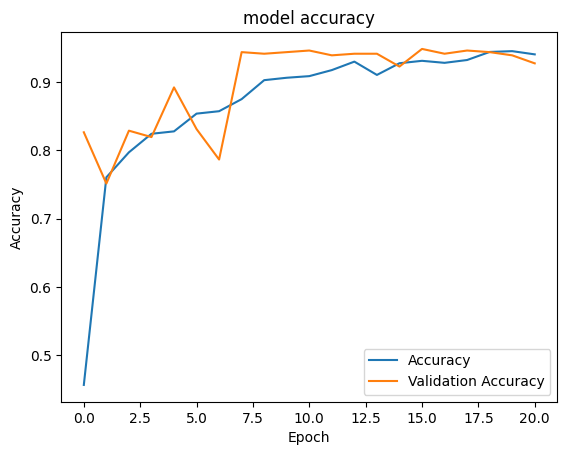

In [11]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

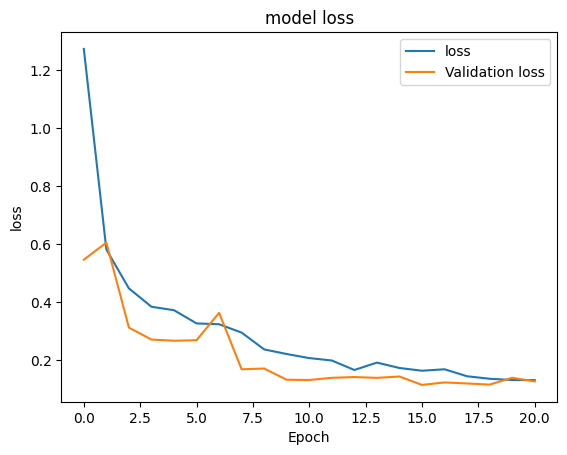

In [10]:
plt.plot(history.history["loss"])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation loss"])
plt.show()

In [13]:
from sklearn.metrics import classification_report

# Utilisez le modèle pour prédire les classes sur les données de validation
y_pred = model.predict(val_generator)
y_true = val_generator.classes

# Convertissez les probabilités prédites en classes prédites (classe avec la probabilité la plus élevée)
y_pred_classes = y_pred.argmax(axis=-1)

# Calcul des métriques de classification
report = classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices, output_dict=True)

# Affichage des métriques pour chaque classe
for class_name, metrics in report.items():
    print(f'Classe : {class_name}')
    print(f'   Précision : {metrics["precision"]}')
    print(f'   Rappel : {metrics["recall"]}')
    print(f'   Score F1 : {metrics["f1-score"]}')
    print(f'   Support : {metrics["support"]}\n')

14/14 [==============================] - 13s 810ms/step
Classe : Looking Away
   Précision : 0.12941176470588237
   Rappel : 0.12941176470588237
   Score F1 : 0.12941176470588237
   Support : 85

Classe : bored
   Précision : 0.14545454545454545
   Rappel : 0.1111111111111111
   Score F1 : 0.12598425196850394
   Support : 72

Classe : confused
   Précision : 0.1891891891891892
   Rappel : 0.1891891891891892
   Score F1 : 0.18918918918918917
   Support : 74

Classe : drowsy
   Précision : 0.14285714285714285
   Rappel : 0.18867924528301888
   Score F1 : 0.16260162601626016
   Support : 53

Classe : engaged
   Précision : 0.18571428571428572
   Rappel : 0.18571428571428572
   Score F1 : 0.18571428571428572
   Support : 70

Classe : frustrated
   Précision : 0.1527777777777778
   Rappel : 0.1527777777777778
   Score F1 : 0.1527777777777778
   Support : 72

Classe : accuracy


TypeError: 'float' object is not subscriptable